In [1]:
import pandas as pd
from functions.displayer import (plot_cycle,
                                 plot_windowed_cycle,
                                 plot_loss,
                                 plot_reconstruction,
                                 plot_mae_per_cycle)
from functions.data_processor import DataProcessor
from models.encoder import Encoder
from models.decoder import Decoder
from models.autoencoder import Autoencoder
from functions.reconstruction import (reconstruct_cycles,
                                      calc_avg_mae_per_cycle)
import matplotlib.pyplot as plt

In [2]:
# PATHs
TRAIN_PATH = 'data/train.csv'
TEST_PATH = 'data/test.csv'

<h1><center>Unsupervised anomaly detection using autoencoders</center></h1>
<h3><center>Multivariate time series - Wafers</center></h3>

-------

## I. Data preparation

#### 1. Data reading

- Read csv files

In [3]:
train = pd.read_csv(TRAIN_PATH)
test = pd.read_csv(TEST_PATH)

- Extract X and y

In [4]:
# Training set
x_train = train[['id', 'value']]
y_train = train.groupby(['id']).apply(lambda X: X.isAnomaly.iloc[0])
# Testing set
x_test = test[['id', 'value']]
y_test = test.groupby(['id']).apply(lambda X: X.isAnomaly.iloc[0])

#### 2. Data description

Data contains a calculated measure based on multiple sensors. This measure is **cyclic** with **152 timestamp per cycle**.

In [5]:
n_train_anomaly = y_train.value_counts()
n_test_anomaly = y_test.value_counts()

In [6]:
print('Train anomaly distribution: ', n_train_anomaly, sep='\n', end='\n\n')
print('Test anomaly distribution: ', n_test_anomaly, sep='\n')

Train anomaly distribution: 
 1    903
-1     97
dtype: int64

Test anomaly distribution: 
 1    5499
-1     665
dtype: int64


#### 3. Data visualization

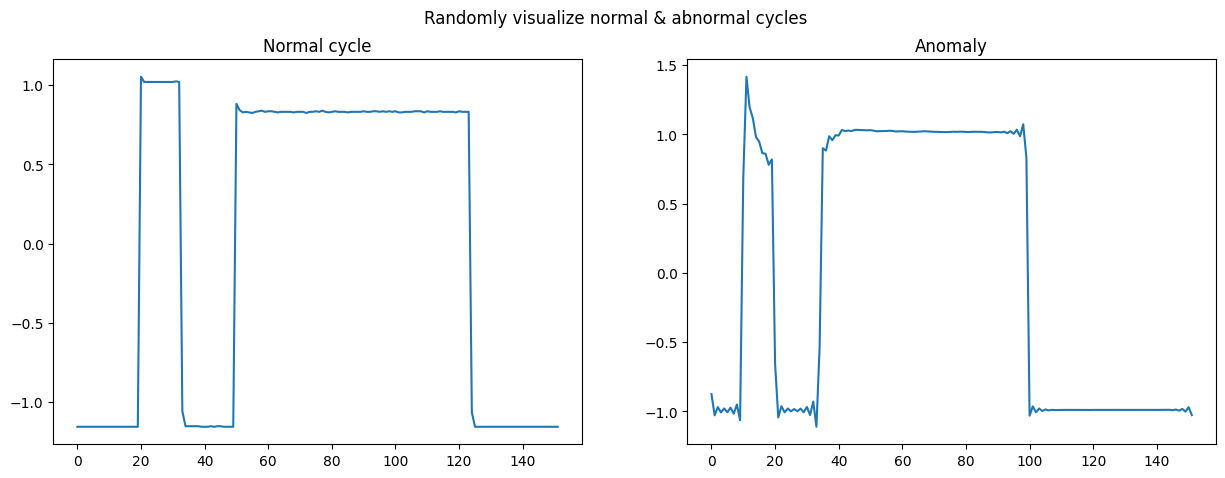

In [7]:
plot_cycle(train)

#### 4. Training set

- The training set for timeseries anomaly detection should be composed exclusively of normal cycles. Since the model's objective is to learn features intrinsic of normal cycles and learn to reconstruct the original series from a small latent space. The error would be higher if the cycle prove to be an anomaly.

In [8]:
x_train = x_train[train.isAnomaly==1].reset_index(drop=True)

#### 5. Data processing 

- Data proccessor parameters

In [9]:
col_names = ['value']
id = 'id'

- Create data processor

In [10]:
dp = DataProcessor(x_train, x_test, col_names, id)

- Scaling data

In [11]:
dp.scale_data()

- Reshaping data

In [12]:
dp.reshape_data()
print(dp.s_train.shape)

(903, 152, 1)


- Windowing: *Size = 12, gap = 4*

In [13]:
dp.windowing(12, 4)

In [14]:
print('Train shape after windowing: ', dp.w_train.shape)

Train shape after windowing:  (32508, 12, 1)


- Visualize windowing overlapping impact

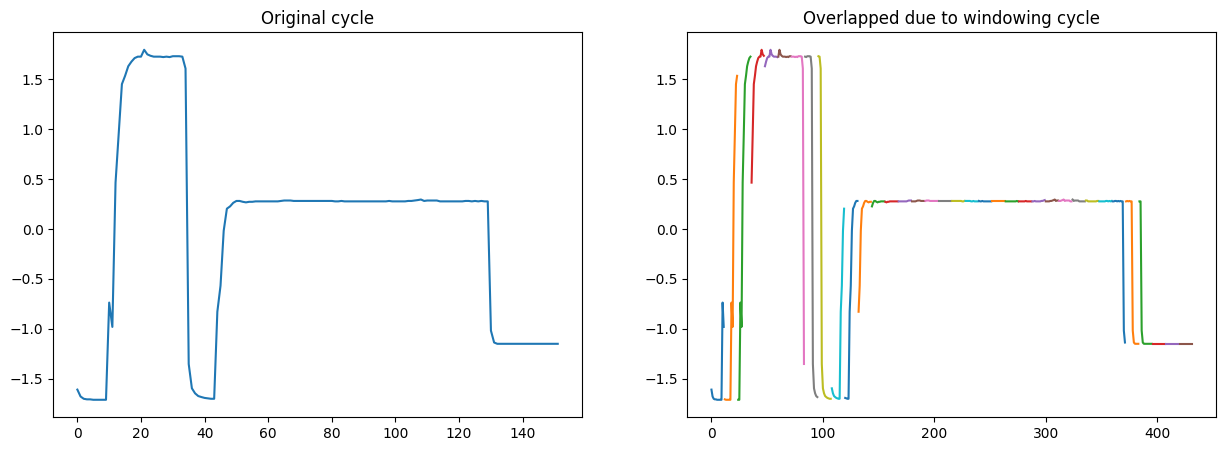

In [15]:
plot_windowed_cycle(dp.s_train, dp.w_train, gap=4)

## II. Training an auto-encoder

#### 0. Dimensions definition

In [16]:
# Training set shape
shape = dp.w_train.shape
# Sub sequence shape
length_sequence = shape[1]
n_features = shape[2]
# Latent dimension 
n_latent = 3

#### 1. Create an LSTM encoder

In [17]:
encoder = Encoder(length_sequence, n_features, n_latent).model

#### 2. Create an LSTM decoder

In [18]:
decoder = Decoder(length_sequence, n_features, n_latent).model

#### 3. Create an auto-encoder

In [19]:
ae = Autoencoder(encoder, decoder).model

#### 4. Compile and explore the auto-encoder

In [20]:
ae.compile(optimizer='adam', loss='mse')
ae.summary()

Model: "Autoencoder-Model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 12, 1)]           0         
                                                                 
 Encoder-Model (Functional)  (None, 3)                 4451      
                                                                 
 Decoder-Model (Functional)  (None, 12, 1)             4641      
                                                                 
Total params: 9,092
Trainable params: 9,092
Non-trainable params: 0
_________________________________________________________________


#### 5. Fitting the model

- Training the model

In [21]:
history = ae.fit(x=dp.w_train,
                 y=dp.w_train,
                 batch_size=32,
                 epochs=10,
                 validation_data=(dp.w_test, dp.w_test))

Epoch 1/10
1016/1016 [==============================] - 26s 23ms/step - loss: 0.1721 - val_loss: 0.0946
Epoch 2/10
1016/1016 [==============================] - 23s 22ms/step - loss: 0.0877 - val_loss: 0.0740
Epoch 3/10
1016/1016 [==============================] - 23s 23ms/step - loss: 0.0703 - val_loss: 0.0605
Epoch 4/10
1016/1016 [==============================] - 24s 23ms/step - loss: 0.0591 - val_loss: 0.0523
Epoch 5/10
1016/1016 [==============================] - 24s 24ms/step - loss: 0.0509 - val_loss: 0.0426
Epoch 6/10
1016/1016 [==============================] - 24s 24ms/step - loss: 0.0463 - val_loss: 0.0369
Epoch 7/10
1016/1016 [==============================] - 24s 23ms/step - loss: 0.0421 - val_loss: 0.0360
Epoch 8/10
1016/1016 [==============================] - 25s 24ms/step - loss: 0.0364 - val_loss: 0.0464
Epoch 9/10
1016/1016 [==============================] - 24s 23ms/step - loss: 0.0332 - val_loss: 0.0303
Epoch 10/10
1016/1016 [==============================] - 24s 24m

- Plotting loss functions

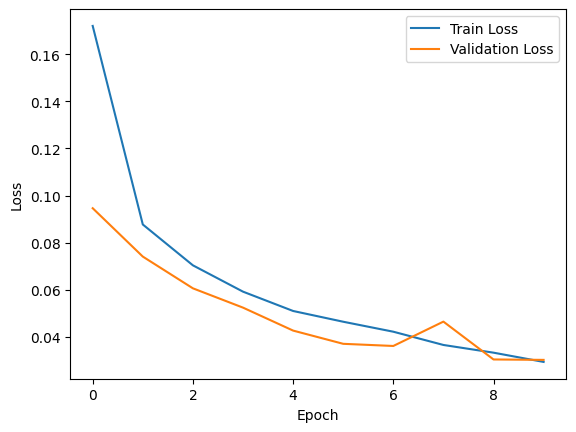

In [22]:
plot_loss(history)

#### 6. Test  windowed prediction

In [23]:
w_pred = ae.predict(dp.w_test)

6935/6935 [==============================] - 20s 3ms/step


#### 7. Visualize a windowed prediction

In [24]:
cycle = 5

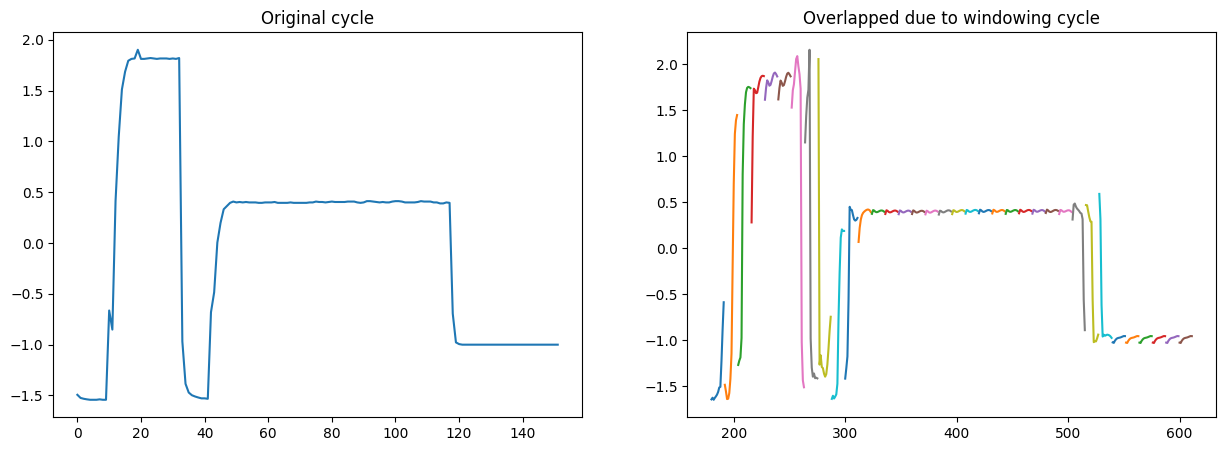

In [25]:
plot_windowed_cycle(dp.s_test, w_pred, cycle=cycle, gap=4)

## III. Reconstruction

#### 1. Transform windowed prediction into reconstructed cycles 

- Calculate reconstructed cycles by keeping gap first timestamp in each subsequence.

In [26]:
r_pred = reconstruct_cycles(w_pred, length=152, sub_length=12, gap=4)

- Plotting reconstructed cycle

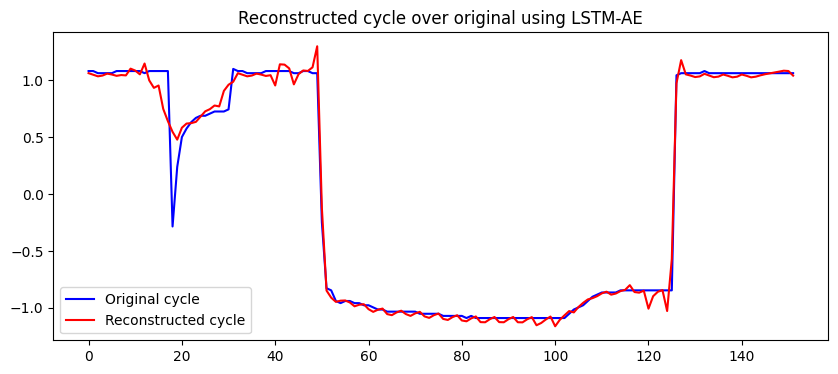

In [34]:
cycle = 6130
plot_reconstruction(dp.s_test, r_pred, cycle)

#### 2. Average reconstruction error per cycle

- Calculate the average mean absolute error (MAE) per cycle between a set of original 3D sequences and their reconstructions.

In [30]:
mae_per_cycle = calc_avg_mae_per_cycle(dp.s_test, r_pred)

- Plotting the average reconstruction error per cycle

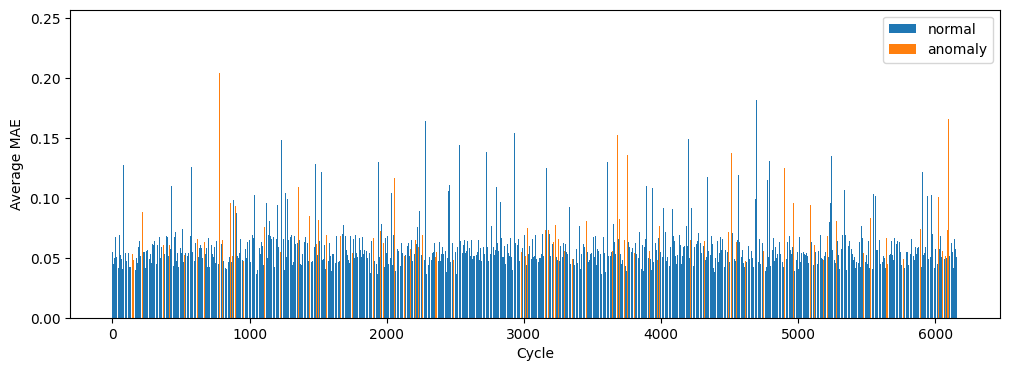

In [31]:
plot_mae_per_cycle(mae_per_cycle, y_test)